In [1]:
# required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# imports -TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Setting random seed-42
import random

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline


In [2]:
# resizing

IMG_HEIGHT = 224
IMG_WIDTH = 224
# from results achieved from random serach
BATCH_SIZE = 16

# Define dataset directory name
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary

# Defining classes under main folder
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [3]:
import shutil
from sklearn.model_selection import train_test_split

# Base directory for splitting dataset
base_dir = 'kidney_split_dataset'  

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # Splitting data and copying all img
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # Copying al training img
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

        # Copying validation img
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

        # Copying test img
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


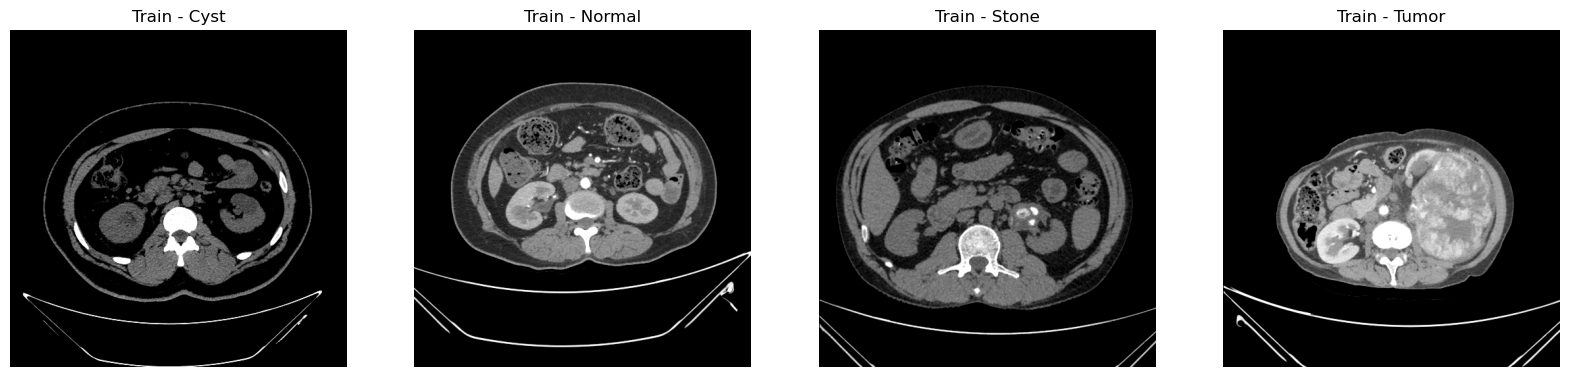

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


def visualize_samples(directory, subset='train'):
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))
    

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{subset.capitalize()} - {class_name}')
        axes[i].axis('off')

    plt.show()

visualize_samples(base_dir, 'train')


In [5]:
def preprocess_image(image):

    # resizing and normalizing images
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def preprocess_sequence(image_paths):
    
    # loading and preprocessing 
    images = [preprocess_image(tf.image.decode_jpeg(tf.io.read_file(img))) for img in image_paths]
    return tf.stack(images, axis=0)  # Stack into a single tensor for 3D CNN or CNN-LSTM


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


In [7]:
# initializing train generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42  
)

# setting class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# validation and test data generators
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42  
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42 
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [8]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D
from tensorflow.keras import Input, Model


# 3 frames in every sequence
sequence_length = 3  

# input specifications
inputs = Input(shape=(sequence_length, IMG_HEIGHT, IMG_WIDTH, 1))

# 3D Convolutional layers 
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x) 

x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

x = Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

# Global pooling for all features
x = GlobalAveragePooling3D()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(len(classes), activation='softmax')(x)

# complie the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 224, 224, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 3, 224, 224, 64)   1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 112, 112, 64)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 112, 112, 128)  221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 56, 56, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 56, 56, 256)    884992

In [9]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)



In [10]:
EPOCHS = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[lr_callback]
)


Epoch 1/20
623/623 [==============================] - 423s 663ms/step - loss: 1.1791 - accuracy: 0.5373 - val_loss: 0.9884 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/20
623/623 [==============================] - 342s 549ms/step - loss: 1.0667 - accuracy: 0.6470 - val_loss: 0.9481 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 3/20
623/623 [==============================] - 333s 535ms/step - loss: 1.0169 - accuracy: 0.6578 - val_loss: 0.9078 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 4/20
623/623 [==============================] - 331s 532ms/step - loss: 0.9179 - accuracy: 0.6760 - val_loss: 0.7751 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 5/20
623/623 [==============================] - 330s 530ms/step - loss: 0.8370 - accuracy: 0.6962 - val_loss: 0.7255 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 6/20
623/623 [==============================] - 361s 579ms/step - loss: 0.7378 - accuracy: 0.7047 - val_loss: 0.5957 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 7/20
623/623 [==========================

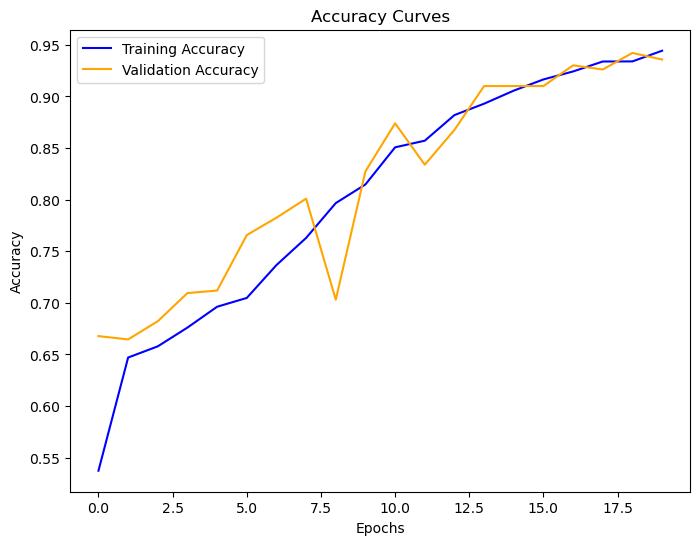

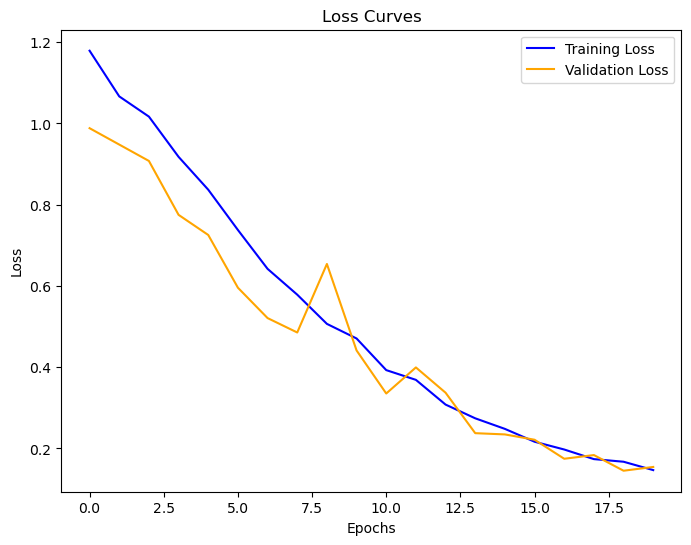

In [11]:
# Function to plot training history
def plot_training_history(history):

    # accuracy curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # loss curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# calling the function to plot training history
plot_training_history(history)


78/78 [==============================] - 23s 300ms/step


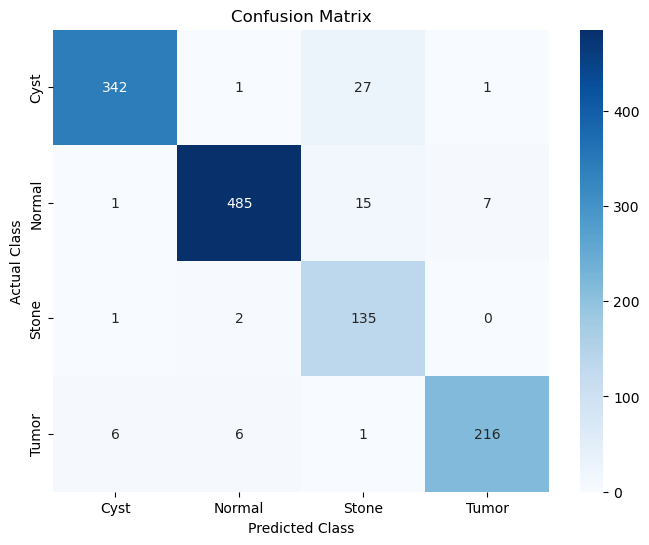

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.92      0.95       371
      Normal       0.98      0.95      0.97       508
       Stone       0.76      0.98      0.85       138
       Tumor       0.96      0.94      0.95       229

    accuracy                           0.95      1246
   macro avg       0.92      0.95      0.93      1246
weighted avg       0.95      0.95      0.95      1246



In [ ]:

def evaluate_model(model, test_generator):

    # prediction on test data set
    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    #  confusion matrix

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()


    # classification report

    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)


evaluate_model(model, test_generator)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# fine tune class weights

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

#altering weight for stone and tumor as they have lesser imgs

# increasing weight for stone by 20%
class_weights_dict[2] *= 1.2

# increasing weight for tumor by 10%  
class_weights_dict[3] *= 1.1  

print("Adjusted class weights for fine-tuning:", class_weights_dict)

fine_tune_epochs = 10  
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    class_weight=class_weights_dict 
)


Adjusted class weights for fine-tuning: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.712261580381471, 3: 1.4999178082191782}
Epoch 1/10
623/623 [==============================] - 349s 561ms/step - loss: 0.1416 - accuracy: 0.9504 - val_loss: 0.1609 - val_accuracy: 0.9334
Epoch 2/10
623/623 [==============================] - 347s 558ms/step - loss: 0.1394 - accuracy: 0.9484 - val_loss: 0.1208 - val_accuracy: 0.9526
Epoch 3/10
623/623 [==============================] - 359s 576ms/step - loss: 0.1351 - accuracy: 0.9526 - val_loss: 0.1250 - val_accuracy: 0.9510
Epoch 4/10
623/623 [==============================] - 361s 580ms/step - loss: 0.1208 - accuracy: 0.9574 - val_loss: 0.0959 - val_accuracy: 0.9639
Epoch 5/10
623/623 [==============================] - 333s 535ms/step - loss: 0.1058 - accuracy: 0.9644 - val_loss: 0.0867 - val_accuracy: 0.9711
Epoch 6/10
623/623 [==============================] - 331s 531ms/step - loss: 0.1038 - accuracy: 0.9641 - val_loss: 0.1091 - val_accuracy:

78/78 [==============================] - 14s 186ms/step


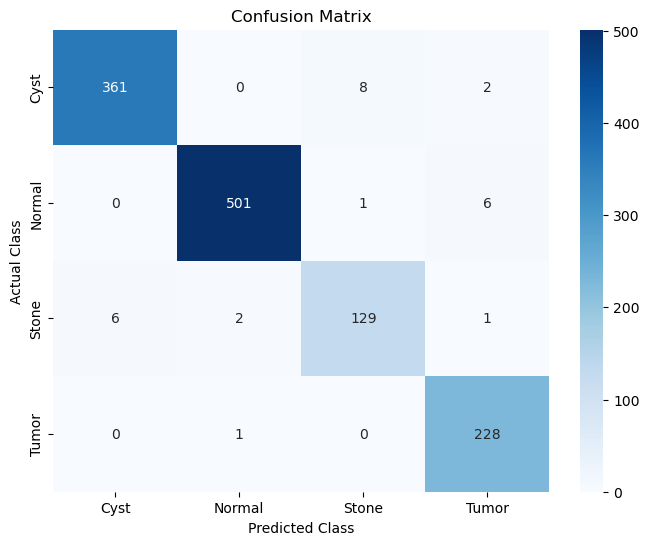

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.97      0.98       371
      Normal       0.99      0.99      0.99       508
       Stone       0.93      0.93      0.93       138
       Tumor       0.96      1.00      0.98       229

    accuracy                           0.98      1246
   macro avg       0.97      0.97      0.97      1246
weighted avg       0.98      0.98      0.98      1246



In [14]:
# re evaluation 
evaluate_model(model, test_generator)
